In [15]:
import typing
import io
import os, re, glob

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

# Conduct the object detection by Yolov5

In [28]:
!cd C:\Users\joechan\Documents\project\AI+ML\image\yolov5
!del /s /q C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\*.*
!rmdir /s /q C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result

!python C:\Users\joechan\Documents\project\AI+ML\image\yolov5\detect.py --source C:\Users\joechan\Documents\project\AI+ML\image\yolov5\data\images\test3.jpg --weights C:\Users\joechan\Documents\project\AI+ML\image\yolov5\checkpoints\best.pt --save-crop --name result

Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\test.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test10.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test11.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test12.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test13.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test14.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test15.jpg
Deleted file - C:\Users\joechan\Documents\project\AI+ML\image\yolov5\runs\detect\result\crops\RBC\test16.jpg
Deleted file - C:\Users\joechan\D

detect: weights=['C:\\Users\\joechan\\Documents\\project\\AI+ML\\image\\yolov5\\checkpoints\\best.pt'], source=C:\Users\joechan\Documents\project\AI+ML\image\yolov5\data\images\test3.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=..\yolov5\runs\detect, name=result, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5  v6.0-149-g407a905 torch 1.10.0+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients
image 1/1 C:\Users\joechan\Documents\project\AI+ML\image\yolov5\data\images\test3.jpg: 640x512 6 RBCs, Done. (0.218s)
Speed: 2.0ms pre-process, 218.0ms inference, 8.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to ..\yolov5\runs\detect\result


In [29]:
listing = glob.glob('../yolov5/runs/detect/result/crops/*/*.jpg')
listing

['../yolov5/runs/detect/result/crops\\RBC\\test3.jpg',
 '../yolov5/runs/detect/result/crops\\RBC\\test32.jpg',
 '../yolov5/runs/detect/result/crops\\RBC\\test33.jpg',
 '../yolov5/runs/detect/result/crops\\RBC\\test34.jpg',
 '../yolov5/runs/detect/result/crops\\RBC\\test35.jpg',
 '../yolov5/runs/detect/result/crops\\RBC\\test36.jpg']

# Define the test input image

In [32]:
#yes_img = "test/test1.jpeg"

yes_img = listing[1]

no_img = "test/no_0012.jpg"

model_path = 'output/test_checkpoint.bin'


In [33]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=2, zero_head=False, img_size=224, vis=True)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def estimation(img_file):
    im = Image.open(img_file).convert('RGB')
    #im = Image.open("test/no_0012.jpg").convert('RGB')
    x = transform(im)
    x.size()
    
    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    # result = (mask * im).astype("uint8")
    # fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    # ax1.set_title('Original')
    # ax2.set_title('Attention Map')
    # _ = ax1.imshow(im)
    # _ = ax2.imshow(result)

    probs = torch.nn.Softmax(dim=-1)(logits)
    pred = torch.argmax(probs, dim=1)
    if pred[0] == 1:
        print("yes", probs)
    else:
        print("no", probs)

estimation(yes_img)

no tensor([[0.9957, 0.0043]], grad_fn=<SoftmaxBackward0>)


In [34]:
for f in listing:
    print(f)
    estimation(f)

../yolov5/runs/detect/result/crops\RBC\test3.jpg
no tensor([[0.9952, 0.0048]], grad_fn=<SoftmaxBackward0>)
../yolov5/runs/detect/result/crops\RBC\test32.jpg
no tensor([[0.9957, 0.0043]], grad_fn=<SoftmaxBackward0>)
../yolov5/runs/detect/result/crops\RBC\test33.jpg
no tensor([[0.8019, 0.1981]], grad_fn=<SoftmaxBackward0>)
../yolov5/runs/detect/result/crops\RBC\test34.jpg
no tensor([[9.9995e-01, 5.1839e-05]], grad_fn=<SoftmaxBackward0>)
../yolov5/runs/detect/result/crops\RBC\test35.jpg
no tensor([[0.9982, 0.0018]], grad_fn=<SoftmaxBackward0>)
../yolov5/runs/detect/result/crops\RBC\test36.jpg
no tensor([[9.9995e-01, 4.7655e-05]], grad_fn=<SoftmaxBackward0>)


# The Prediction - Demo

In [26]:
im = Image.open(yes_img).convert('RGB')
#im = Image.open("test/no_0012.jpg").convert('RGB')
x = transform(im)
x.size()

logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

no


tensor([[9.9996e-01, 4.2824e-05]], grad_fn=<SoftmaxBackward0>)

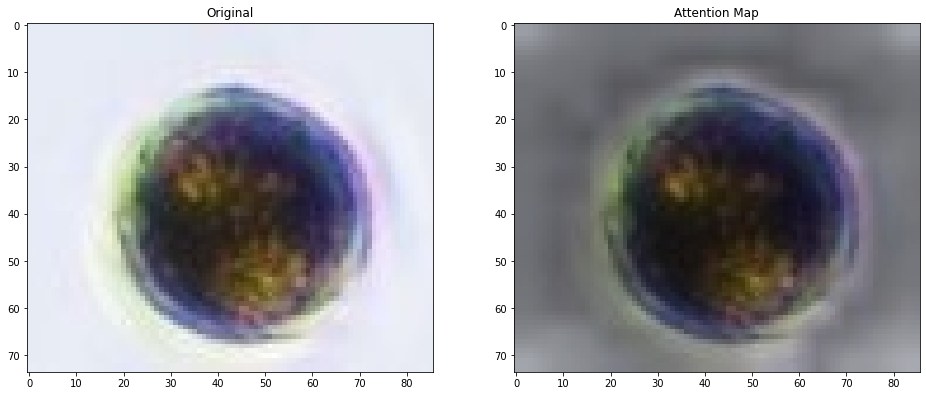

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
pred = torch.argmax(probs, dim=1)
if pred[0] == 1:
    print("yes")
else:
    print("no")
    
probs

# top5 = torch.argsort(probs, dim=-1, descending=True)
# print("Prediction Label and Attention Map!\n")
# for idx in top5[0, :5]:
#     print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

In [79]:
im = Image.open(no_img).convert('RGB')
x = transform(im)
x.size()

logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

no


tensor([[9.9999e-01, 7.7915e-06]], grad_fn=<SoftmaxBackward0>)

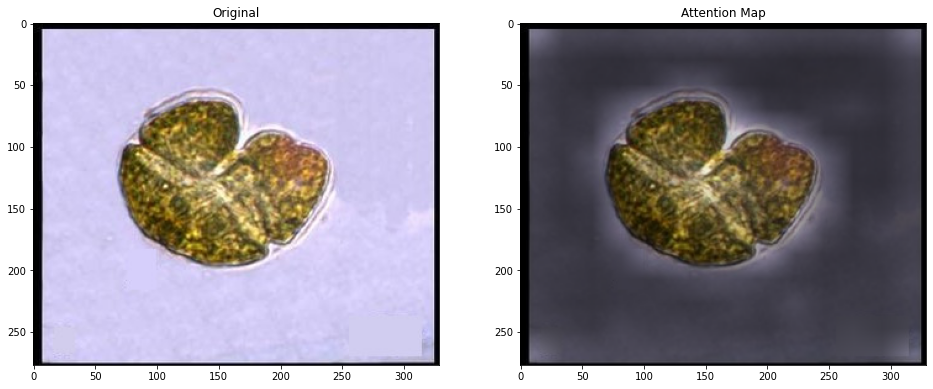

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
pred = torch.argmax(probs, dim=1)
if pred[0] == 1:
    print("yes")
else:
    print("no")
    
probs
# top5 = torch.argsort(probs, dim=-1, descending=True)
# print("Prediction Label and Attention Map!\n")
# for idx in top5[0, :5]:
#     print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')